Loading and Visualizing the Audio Signal

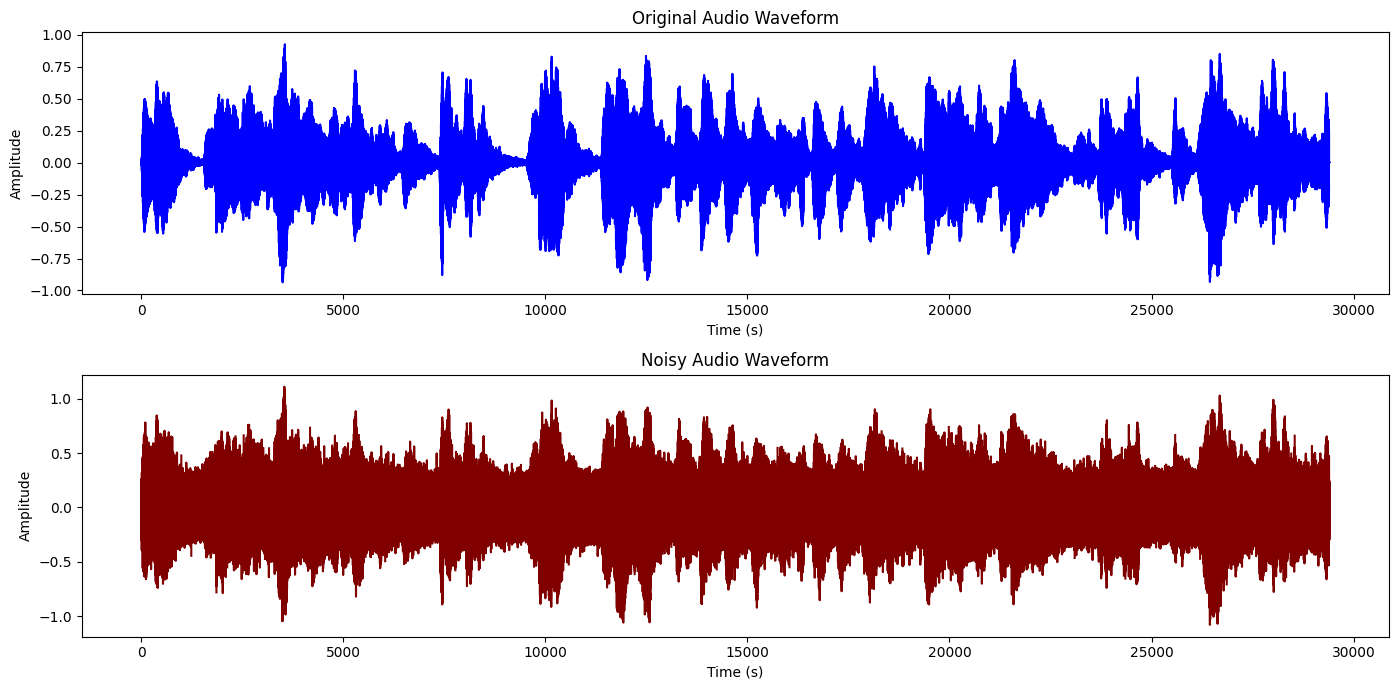

In [14]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
audio_path = 'arp-space-190694.mp3'
y, sr = librosa.load(audio_path)

# Parameters for noise generation
sigma_e = 0.5  # Variance of white noise sequence e(t)
sigma_w = 0.2  # Variance of white noise sequence w(t)
sigma_z = 0.1  # Variance of broadband noise z(t)

# Generate white noise sequences e(t), w(t), and z(t)
T = len(y)
e = np.random.normal(0, sigma_e, T)
w = np.random.normal(0, sigma_w, T)
z = np.random.normal(0, sigma_z, T)

# Generate impulsive noise v(t)
v = np.zeros(T)
# Assuming clicks occur randomly with a certain probability
click_probability = 0.05
for t in range(T):
    if np.random.rand() < click_probability:
        v[t] = np.random.choice([-np.inf, np.inf])  # Infinite variance for clicks

# Add noise components to the audio signal to obtain the noisy signal
y_noisy = y + z + v

# Calculate the time array for plotting
time = librosa.times_like(y, sr=sr)

# Plot original and noisy waveforms in subplots
plt.figure(figsize=(14, 7))

# Original waveform subplot
plt.subplot(2, 1, 1)
plt.plot(time, y, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original Audio Waveform')

# Noisy waveform subplot
plt.subplot(2, 1, 2)
plt.plot(time, y_noisy, color='maroon')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Noisy Audio Waveform')

plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()


Functions

In [34]:
import numpy as np

# Define the process and measurement models
def process_model(x, A_q, b_q, e, w):
    """
    Process model function
    
    Parameters:
        x (numpy array): State vector at time t
        A_q (numpy array): Companion matrix associated with extended parameter vector a_q
        b_q (numpy array): Coefficient vector for the noise term
        e (float): White noise sequence e(t)
        w (numpy array): White noise sequence w(t)
    
    Returns:
        numpy array: Predicted state vector at time t+1
    """
    p = len(w)
    x_pred = np.dot(A_q, x) + np.concatenate((b_q * e, w))
    return x_pred

def measurement_model(x, c, zeta):
    """
    Measurement model function
    
    Parameters:
        x (numpy array): State vector at time t
        c (numpy array): Measurement coefficient vector
        zeta (float): Combined noise term
    
    Returns:
        float: Measured output at time t
    """
    return np.dot(c, x) + zeta

def linearize_process_model(x_hat, A_q, s_p, p):
    """
    Linearization of the process model
    
    Parameters:
        x_hat (numpy array): Filtered state trajectory (x^T(t|t))
        A_q (numpy array): Companion matrix associated with extended parameter vector a_q
        s_p (numpy array): Vector composed of the first p components of s_q(t|t)
        p (int): AR model order
    
    Returns:
        numpy array: Jacobian matrix representing the linearized process model (F)
    """
    q = len(x_hat)
    F = np.zeros((q, q))  # Initialize F as a square matrix with dimensions (q, q)
    F[:p, :p] = A_q  # Assign A_q to the upper-left block of F
    F[p:, :p] = np.eye(p)  # Identity matrix for the lower-left block of F
    F[p:, p:] = np.eye(p)  # Identity matrix for the lower-right block of F
    return F


def calculate_Omega(b_q, sigma_e, sigma_w):
    """
    Calculate the covariance matrix Omega
    
    Parameters:
        b_q (numpy array): Coefficient vector for the noise term
        sigma_e (float): Variance of white noise sequence e(t)
        sigma_w (float): Variance of white noise sequence w(t)
    
    Returns:
        numpy array: Covariance matrix Omega
    """
    p = len(b_q)
    xi = sigma_w ** 2 / sigma_e ** 2
    Omega = np.zeros((p + 1, p + 1))
    Omega[0, 0] = np.dot(b_q, b_q.T)
    Omega[1:, 1:] = xi * np.eye(p)
    return Omega


def predict(x_hat_prev, Sigma_prev, F, Omega):
    """
    Perform the prediction step of the Kalman filter.
    
    Parameters:
        x_hat_prev (numpy array): Previous state estimate (x_hat(t|t-1))
        Sigma_prev (numpy array): Previous state covariance estimate (Sigma(t|t-1))
        F (numpy array): Jacobian matrix representing the linearized process model
        Omega (numpy array): Covariance matrix representing the process noise
    
    Returns:
        numpy array: Predicted state estimate (x_hat(t|t))
        numpy array: Predicted state covariance estimate (Sigma(t|t))
    """
    # Predicted state estimate
    x_pred = np.dot(F, x_hat_prev)
    
    # Predicted state covariance estimate
    Sigma_pred = np.dot(np.dot(F, Sigma_prev), F.T) + Omega
    
    return x_pred, Sigma_pred

def update(x_pred, Sigma_pred, y, c, sigma_z, d_hat):
    """
    Perform the update step of the Kalman filter.
    
    Parameters:
        x_pred (numpy array): Predicted state estimate (x_hat(t|t))
        Sigma_pred (numpy array): Predicted state covariance estimate (Sigma(t|t))
        y (float): Measurement at time t
        c (numpy array): Measurement matrix
        sigma_z (float): Variance of measurement noise
        d_hat (int): Click indicator function
    
    Returns:
        numpy array: Updated state estimate (x_hat(t|t))
        numpy array: Updated state covariance estimate (Sigma(t|t))
    """
    # Innovation
    epsilon = y - np.dot(c, x_pred)
    
    # Kalman gain
    if d_hat == 0:
        K = np.dot(Sigma_pred, c) / (np.dot(np.dot(c, Sigma_pred), c.T) + sigma_z)
    else:
        K = np.zeros_like(Sigma_pred)
    
    # Updated state estimate
    x_update = x_pred + np.dot(K, epsilon)
    
    # Updated state covariance estimate
    Sigma_update = np.dot(np.eye(len(x_pred)) - np.dot(K, c), Sigma_pred)
    
    return x_update, Sigma_update


def detect_click(epsilon, mu, sigma_epsilon_hat):
    """
    Detect clicks based on the prediction error.
    
    Parameters:
        epsilon (float): Prediction error at time t
        mu (float): Threshold parameter for detection of impulsive noise
        sigma_epsilon_hat (float): Estimated innovation variance
    
    Returns:
        int: Detected click (0 for no click, 1 for click)
    """
    if abs(epsilon) <= mu * sigma_epsilon_hat:
        return 0  # No click
    else:
        return 1  # Click detected

def update_innovation_variance(sigma_epsilon_prev, epsilon, c, Sigma_prev, k):
    """
    Update the estimated innovation variance.
    
    Parameters:
        sigma_epsilon_prev (float): Previous estimated innovation variance
        epsilon (float): Prediction error at time t
        c (numpy array): Measurement matrix
        Sigma_prev (numpy array): Previous state covariance estimate (Sigma(t|t-1))
        k (numpy array): Kalman gain
    
    Returns:
        float: Updated estimated innovation variance
    """
    # Calculate eta
    eta_t = np.dot(np.dot(c, Sigma_prev), c.T) + k
    
    # Update the estimated innovation variance
    if detect_click(epsilon, mu, sigma_epsilon_prev) == 0:
        sigma_epsilon_t = lambda_val * sigma_epsilon_prev + (1 - lambda_val) * (epsilon ** 2 / eta_t)
    else:
        sigma_epsilon_t = sigma_epsilon_prev
    
    return sigma_epsilon_t


def ewls_update(x_hat_prev, Sigma_prev, epsilon, c, gamma):
    """
    Perform the update step of the Exponentially Weighted Least Squares (EWLS) algorithm.
    
    Parameters:
        x_hat_prev (numpy array): Previous state estimate (x_hat(t|t-1))
        Sigma_prev (numpy array): Previous state covariance estimate (Sigma(t|t-1))
        epsilon (float): Prediction error (Kalman filter innovation) at time t
        c (numpy array): Measurement matrix
        gamma (float): EWLS parameter (0 < gamma < 1)
    
    Returns:
        numpy array: Updated state estimate (x_hat(t|t))
        numpy array: Updated state covariance estimate (Sigma(t|t))
    """
    # Kalman gain for EWLS
    L = np.dot(Sigma_prev, c) / (np.dot(np.dot(c, Sigma_prev), c.T))
    
    # Updated state estimate for EWLS
    x_update = x_hat_prev + np.dot(L, epsilon)
    
    # Updated covariance estimate for EWLS
    Sigma_update = (1 / gamma) * (Sigma_prev - np.outer(L, np.dot(Sigma_prev, c.T)))
    
    return x_update, Sigma_update


Processing Code

In [45]:
# Load the audio file
audio_path = 'arp-space-190694.mp3'
y, sr = librosa.load(audio_path)

# Parameters for noise generation
sigma_e = 0.5  # Variance of white noise sequence e(t)
sigma_w = 0.2  # Variance of white noise sequence w(t)
sigma_z = 0.1  # Variance of broadband noise z(t)

# Generate white noise sequences e(t), w(t), and z(t)
T = len(y)
e = np.random.normal(0, sigma_e, T)
w = np.random.normal(0, sigma_w, T)
z = np.random.normal(0, sigma_z, T)

# Generate impulsive noise v(t)
v = np.zeros(T)
# Assuming clicks occur randomly with a certain probability
click_probability = 0.05
for t in range(T):
    if np.random.rand() < click_probability:
        v[t] = np.random.choice([-np.inf, np.inf])  # Infinite variance for clicks

# Add noise components to the audio signal to obtain the noisy signal
y_noisy = y + z + v

# Calculate the time array for plotting
time = librosa.times_like(y, sr=sr)

# Reconstruction using Extended Kalman Filter
# Initialize state vector and covariance matrix
q = len(y)
x_hat = np.zeros(q)
Sigma = np.eye(q)

# Initialize lists to store restored audio
restored_audio = []

# Perform prediction and update steps for each time step
for t in range(T):
    # Predict step
    x_pred, Sigma_pred = predict(x_hat, Sigma, F, Omega)
    
    # Measurement model
    y_pred = measurement_model(x_pred, np.array([1]), 0)
    
    # Update step
    d_hat = detect_click(epsilon_list[t], mu, np.sqrt(Sigma_pred[0, 0]))
    if d_hat == 0:
        x_update, Sigma_update = update(x_pred, Sigma_pred, y_noisy[t], np.array([1]), sigma_z, d_hat)
    else:
        x_update, Sigma_update = ewls_update(x_pred, Sigma_pred, epsilon_list[t], np.array([1]), gamma)
    
    # Store restored audio
    restored_audio.append(y_pred)

    # Update state vector and covariance matrix
    x_hat = x_update
    Sigma = Sigma_update

# Plotting
plt.figure(figsize=(10, 8))

# Original audio subplot
plt.subplot(3, 1, 1)
plt.plot(time, y, color='blue', alpha=0.7, label='Original Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

# Noisy audio subplot
plt.subplot(3, 1, 2)
plt.plot(time, y_noisy, color='red', alpha=0.7, label='Noisy Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

# Restored audio subplot
plt.subplot(3, 1, 3)
plt.plot(time, restored_audio, color='green', linestyle='--', label='Restored Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

MemoryError: Unable to allocate 11.7 TiB for an array with shape (1266048, 1266048) and data type float64

Evaluation Code

In [42]:
# Calculate Signal-to-Noise Ratio (SNR)
def calculate_snr(original_signal, restored_signal):
    power_original = np.sum(original_signal ** 2)
    power_noise = np.sum((original_signal - restored_signal) ** 2)
    snr = 10 * np.log10(power_original / power_noise)
    return snr

# Calculate Mean Squared Error (MSE)
def calculate_mse(original_signal, restored_signal):
    mse = np.mean((original_signal - restored_signal) ** 2)
    return mse

# Calculate SNR and MSE
snr_value = calculate_snr(y, restored_audio)
mse_value = calculate_mse(y, restored_audio)

print("SNR:", snr_value)
print("MSE:", mse_value)

ValueError: operands could not be broadcast together with shapes (1266048,) (0,) 